# Spam Detection Excercise
## Matt Steele  -   8/28/2017

In the following excercise a basic spam/ham classifier is constructed to classify an courpus of documents from an online source.

The excercise is divided into four basic sections:
  1. Data Exploration and Cleaning
  2. Feature Selection
  3. Model Construction
  4. Validation and Performance Testing
  
## Data Exploration and Cleaning

In the data exploration phase the data is examined to inspect for encoding scheme, missing data, ham/spam distributions, and quick inspection of language usage. Since the scope and timeframe of this work is limited this exploration/clean serves primarily to weed-out potential "gotchas" and data irregularities that will interfer with downstream analysis. In a more thourough data exploration the text will be examined in finer detail, with an eye toward potential feature identification.


In [36]:
%matplotlib notebook
import nltk
import pandas as pd
import numpy as np

#read data to pandas data table
datIn = pd.read_csv("trainingSet.psv",sep="|",encoding="utf-8")

datIn

,target,text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
5,ham,As per your request 'Melle Melle (Oru Minnamin...
6,spam,WINNER!! As a valued network customer you have...
7,spam,Had your mobile 11 months or more? U R entitle...
8,ham,I'm gonna be home soon and i don't want to tal...
9,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [5]:
#check encoding for target field
datIn['target'].unique()

array(['ham', 'spam'], dtype=object)

In [8]:
#check spam ham distribution
datIn['target'].value_counts()

ham     4824
spam     746
Name: target, dtype: int64

In [6]:
#check for missing values
datIn.isnull().sum()

target    0
text      0
dtype: int64

In [42]:
#change target encoding (ham=0, spam=1)
datIn['target'] = np.where(datIn['target']=='spam',1,0)

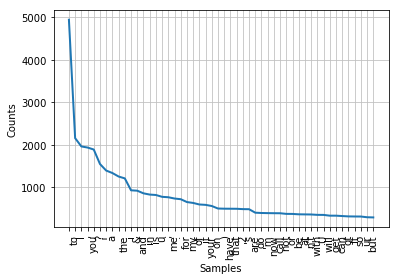

In [17]:
#construct nltk.Text format object
tokens = nltk.word_tokenize(datIn['text'].str.cat(sep=' '))
text = nltk.Text(tokens)

#and examine token distribution
dist = nltk.FreqDist(text)
dist.plot(50)

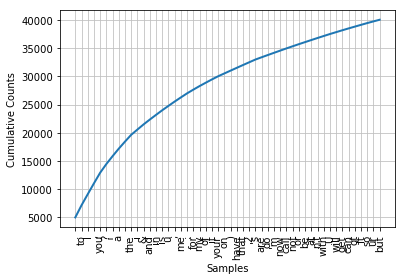

In [18]:
#cumulative distribution
dist.plot(50, cumulative=True)

In [16]:
#most frequent tokens
dist.most_common(20)

[('.', 4939),
 ('to', 2157),
 ('I', 1962),
 (',', 1936),
 ('you', 1889),
 ('?', 1549),
 ('!', 1395),
 ('a', 1337),
 ('...', 1255),
 ('the', 1211),
 ('i', 931),
 ('&', 922),
 ('and', 860),
 ('in', 831),
 ('is', 821),
 ('u', 778),
 (';', 768),
 ('me', 738),
 (':', 722),
 ('for', 655)]

In [61]:
from sklearn.model_selection import train_test_split

#split test-training set using 75/25 split
X_train, X_test, y_train, y_test = train_test_split(datIn['text'], 
                                                    datIn['target'], 
                                                    random_state=0)

## Feature Selection

In this section we examine two non-token features commonly used to identify spam; the inclusion of numeric characters, and document length. In this quick inspection we test to see if the distributions of these metrics are sufficiently different across the ham/spam data subsets to provide predictive power.

The feature set is then extracted from the text including:
  - Unigrams: Single tokens (words, numbers, and punctuation marks)
  - Bigrams: Phrases of to sequential tokens
  - Document length: Number of characters in the document
  - Digits: Number of digit characters in the document


<IPython.core.display.Javascript object>


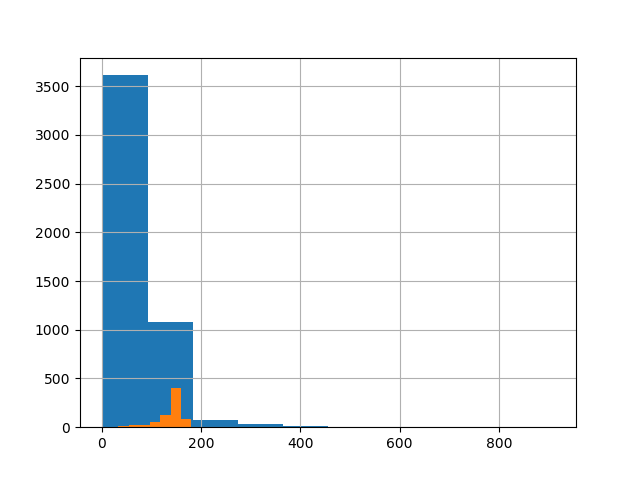

{'ham length': 71.47719734660033, 'spam length': 138.66487935656838}

In [90]:
#test if document length is diagnostic
import matplotlib.pyplot as plt

spamIndex = datIn["target"]==1
    
hamLen = pd.Series([len(x) for x in datIn.loc[-spamIndex,"text"]])
spamLen = pd.Series([len(x) for x in datIn.loc[spamIndex,"text"]])

fig1=plt.figure(1)
hamLen.hist()
spamLen.hist()
plt.show()
#plt.close(fig1)
{'ham length':np.mean(hamLen),'spam length':np.mean(spamLen)}


In [56]:
from scipy.stats import describe

#test if number inclusion is diagnostic
hamDigits = [sum(char.isdigit() for char in string) for string in datIn.loc[-spamIndex,"text"]]
spamDigits = [sum(char.isdigit() for char in string) for string in datIn.loc[spamIndex,"text"]]

#describe(spamDigits)
pd.DataFrame({'ham':describe(hamDigits),'spam':describe(spamDigits)},
             index=np.array(['N','Min Max','Mean','Variance','Skewness','Kurtosis']))

,ham,spam
N,4824,746
Min Max,"(0, 23)","(0, 47)"
Mean,0.305348,15.8284
Variance,1.15182,75.9571
Skewness,7.43731,0.0386407
Kurtosis,85.5305,-0.236544


In [62]:
from sklearn.feature_extraction.text import CountVectorizer

#Build feature set using unigram and bigram feature extraction, with minimum inclusion threshold of 5
vect = CountVectorizer(min_df=5,ngram_range=(1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
    


In [63]:
#Convience function for adding new features to sklearn feature set
#Originaly published in University of Michigan/Coursera "Text Mining in Python"

def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')



In [64]:
#add character length feature
X_train_vectorized = add_feature(X_train_vectorized,np.array([len(x) for x in X_train]))
X_test_vectorized = add_feature(X_test_vectorized,np.array([len(x) for x in X_test]))
    

In [ ]:
#add number of digits feature
X_train_vectorized = add_feature(X_train_vectorized,np.array([sum(char.isdigit() for char in string) for string in X_train]))
X_test_vectorized = add_feature(X_test_vectorized,np.array([sum(char.isdigit() for char in string) for string in X_test]))

In [68]:
#scale features
from sklearn import preprocessing

scaleFn = preprocessing.MaxAbsScaler().fit(X_train_vectorized)
X_train_scaled = scaleFn.transform(X_train_vectorized)
X_test_scaled = scaleFn.transform(X_test_vectorized)

## Model Construction

A multinomial Naive Bayes algorithm is selected for the classification modeling. Naive Bayes classifiers are a standard model used for spam classification, with well known performance characters the textual data sets.

In [71]:
from sklearn.naive_bayes import MultinomialNB

#Define and fit model
model = MultinomialNB(alpha=0.1)
model.fit(X_train_scaled, y_train)
    

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

## Validation and Performance Testing

To test the peformance of the predictive classification model the data was split using a 75%/25% training/testing split. The test data set was then used to evaluate the performance of the scoring model using three standard metrics.
  - Confusion Matrix: A table including the number of True Positve, False Postive, False Negative, and True Negative predictions
  - Precision-recall curve: A plot that shows the trade off of the false positive and false negative rates based on the decision boundry
  - ROC AUC: A single metric that evaluates the probability that any given ham and spam document will be classified correctly

In [85]:
#generate predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:,1]


In [75]:
#confusion matix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,predictions)

array([[1185,    3],
       [  18,  187]])

<IPython.core.display.Javascript object>


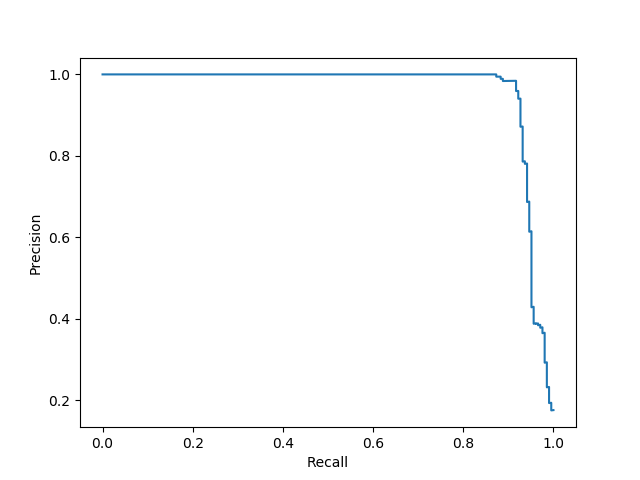

In [91]:
#precision recall curve
from sklearn.metrics import precision_recall_curve

precision,recall, _ = precision_recall_curve(y_test,probabilities)

fig2=plt.figure(2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [93]:
#ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, probabilities) 
    

0.97858257370452484

## Conclusion

The performance the predictive model presented above is fairly good for the limited development time availible. It likely, however, would not generalize well in the wild. Spam detection is a class of problems that is notorious for having a moving target. The generators of spam constantly evolve their approaches and text structures to avoid the features identified in spam detection algorithms. While the above analysis works well for this data set, to be used in the wild a period review of new data would need to be scheduled to identify new features appearing in spam and monitor performance of the predictive algorithms.

If this work were continued for development addition work would be necessary in the areas of the feature selection and model building. As noted above spam detection is well known for having a shifting set of features that characterize spam documents. In the above the analysis was limited to two well-know features of spam. There exist additional known features and document metadata that should be added to a production model. Other examples of known features with predictive power would be capitalization fraction and non-alpha numeric character fraction.  As simple naive bayes classifier was selected for performance, but also expediency. Additional more sophisticated algorithms should be evaluated for a production environment such as maximum entropy models and support vector machines.